# Introduction

Covid has taken a big hit on the restuarant industry. New York is known for their cuisine and we wanted to see the updated resluts for Japanese restuarants. Since covid is calming down a little and the vaccine is out, this might be a good time to start to think about opening up a restuarant. This will answer where in New York should an investor open a Japanese resuarant.

# Data

data was contained though: https://cocl.us/new_york_dataset

# Methodology

ForSquare will be used to locate all venues. Data will be sorted based on ranking and graphs will be created the visualize the data.


# Results

Brooklyn and Manhattan have the best rating per borough with East Village having the highest rating for neighborhood. 

In [31]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

Solving environment: ...working... done

# All requested packages already installed.



In [32]:
CLIENT_ID = 'Q3SXENX45SA3R04B4P4UENC1NSS4ADAEHJKT5U4MVUG5D5PY' 
CLIENT_SECRET = 'J2SAV2PRUSL5AXK2IVKIO53YFCWEF4IGXPWIQBZNSGBDH03V'
VERSION = '20180605' # Foursquare API version

In [33]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [34]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


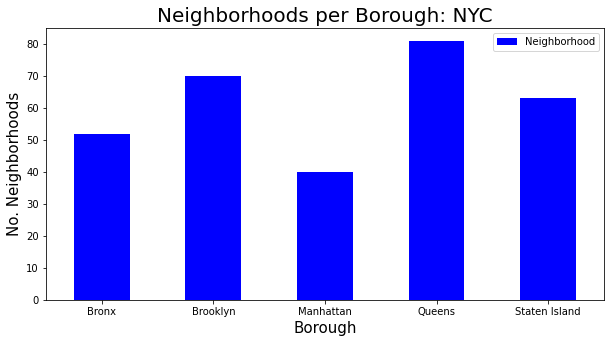

In [36]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [37]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

In [42]:
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
60,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA)
61,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
62,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
63,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
64,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou


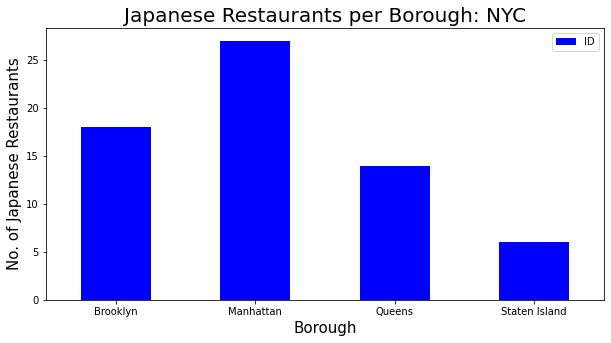

In [40]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [44]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
21,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
22,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
23,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
38,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


In [45]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '6026be34443e2c5300500087'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

KeyError: 'venue'

In [46]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv')

In [47]:
japanese_rest_stats_ny.shape

(50, 7)

In [48]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [49]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [51]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1053
Rating                               8.5
Tips                                 265
Name: 48, dtype: object

In [52]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              510c85e7e4b0056826b88297
Name                                Kura
Likes                                213
Rating                               9.3
Tips                                  63
Name: 25, dtype: object

In [53]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                793
Rating                               8.9
Tips                                 353
Name: 24, dtype: object

In [54]:
# Average Rating of Restuarants among Neighborhood 
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,East Village,9.3
8,Cobble Hill,9.1
30,North Side,9.0
22,Lindenwood,8.9
1,Boerum Hill,8.9
6,Chelsea,8.9
12,Fort Greene,8.8
9,Downtown,8.8
31,Park Slope,8.8
35,Soho,8.7


In [55]:
# Average Rating of Restuarants among Borough 
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.360000
0,Brooklyn,8.326667
2,Queens,6.755556
3,Staten Island,5.916667


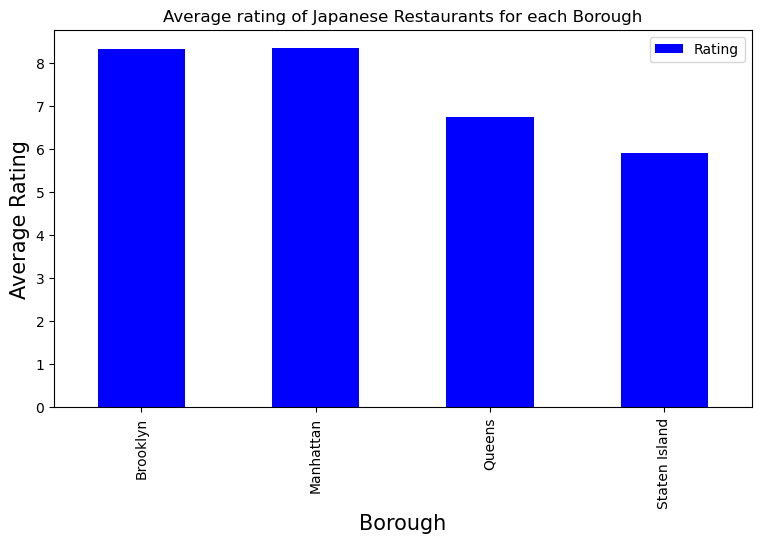

In [56]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [59]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.30
1,Boerum Hill,8.90
2,Brooklyn Heights,8.20
6,Chelsea,8.90
8,Cobble Hill,9.10
9,Downtown,8.80
10,East Village,9.30
12,Fort Greene,8.80
13,Fort Hamilton,8.10
17,Hamilton Heights,8.10


In [60]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.30
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.90
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.20
3,Manhattan,Chelsea,40.744035,-74.003116,8.90
4,Staten Island,Chelsea,40.594726,-74.189560,8.90
5,Brooklyn,Cobble Hill,40.687920,-73.998561,9.10
6,Brooklyn,Downtown,40.690844,-73.983463,8.80
7,Manhattan,East Village,40.727847,-73.982226,9.30
8,Brooklyn,Fort Greene,40.688527,-73.972906,8.80
9,Brooklyn,Fort Hamilton,40.614768,-74.031979,8.10


In [61]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [62]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)